In [1]:
# Imports
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Intro
The relationship between musica  characteristics of each song and the popularity of each song is important for music production and song artists companies to create the next bit songs hits. The Spotify dataset contains songs that were on the Top 200 Weekly Global charts for Spotify in 2020 & 2021 along with each song’s genre, song artist id, and various musical attributes. The popularity score of each song is a number ranging from 0 to 100 that is used by Spotify to rank each song’s popularity. In this project, we will attempt to predict song popularity based on both song metadata as well as musical features generated by Spotify in-house algorithms. Our classification algorithm can be used by musical production comapnies and song artists to gauge how successful each candidate song would be.

# Data Prep

This dataset contains songs that were on the Top 200 Weekly Global charts for Spotify in 2020 & 2021. For each song, we have the following features.

| Feature                   | Feature Type |
|---------------------------|--------------|
| Highest Charting Position | Numeric      |
| Number of Times Charted   | Numeric      |
| Song Name                 | Categorical  |
| Song ID                   | Categorical  |
| Artist                    | Categorical  |
| Streams                   | Numeric      |
| Artist Followers          | Numeric      |
| Genre                     | Categorical  |
| Release Date              | Numeric      |
| Weeks Charted             | Numeric      |
| Popularity                | Numeric      |
| Danceability              | Numeric      |
| Acousticness              | Numeric      |
| Energy                    | Numeric      |
| Instrumentalness          | Numeric      |
| Loudness                  | Numeric      |
| Speechiness               | Numeric      |
| Tempo                     | Numeric      |
| Valence                   | Numeric      |
| Chord                     | Numeric      |



In [2]:
# Entire Dataset
path = 'spotify_dataset.csv'
data = pd.DataFrame(pd.read_csv(path))
data.head()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


## Cleaning the dataset

We will exclude Song Name and Song ID from our feature set. 

In [3]:
# columns corresponding to: index, song name, song id
columns_to_exclude = [0, 4, 8]
data.drop(columns=data.columns[columns_to_exclude], inplace=True)

### Mapping Categorical Features to Classes

In [4]:
# Converting each artist to a class
artists = data['Artist'].tolist()
artists_set = set()
for artist in artists:
    multiple_artists = artist.split(", ")
    for each_artist in multiple_artists:
        artists_set.add(each_artist)

classes = range(len(artists_set))
artists_to_class = dict(zip(artists_set, classes))

# Adding classes as a column
artist_column = [[artists_to_class.get(each_artist) for each_artist in artist.split(", ")] for artist in artists]
data.insert(5, 'Artist_Class', artist_column)

In [5]:
# Converting each chord to a class
chords = set(data['Chord'].tolist())

classes = range(len(chords))
chords_to_class = dict(zip(chords, classes))

# Adding classes as a column
chord_column = [chords_to_class.get(chord_name) for chord_name in data['Chord'].tolist()]
data['Chord_Class'] = chord_column

In [6]:
# Binning genres
def cat_onehot(feat_name):
    cat_feats = data[feat_name].tolist()
    genres = set()
    for feat_list in cat_feats:
        temp = feat_list.replace("'", "")
        temp = temp.replace("[", "")
        temp = temp.replace("]", "")
        temp = temp.replace(" ", "")
        feats  = temp.split(",")
        for feat in feats:
            if "pop" in feat:
                genres.add("pop")
            elif "rock" in feat:
                genres.add("rock")
            elif "rap" in feat:
                genres.add("rap")
            elif "hiphop" in feat:
                genres.add("hiphop")
            else:
                genres.add(feat)
    print(genres)
    print(len(genres))

cat_onehot("Genre")

{'', 'torchsong', 'ranchera', 'showtunes', 'vocaljazz', 'r&bbrasileiro', 'brostep', 'irishsinger-songwriter', 'aussietronica', 'germantechno', 'newromantic', 'vancouverindie', 'soundtrack', 'vegasindie', 'newwave', 'madchester', 'deepeurohouse', 'singer-songwriter', 'lounge', 'quietstorm', 'hollywood', 'afrofuturism', 'hiphop', 'chicagodrill', 'melodicmetalcore', 'bedroomsoul', 'indier&b', 'germandrill', 'regionalmexican', 'weirdcore', 'folkpunk', 'urbancontemporary', 'mellowgold', 'nouvellechansonfrancaise', 'countryroad', 'r&benespanol', 'pop', 'grime', 'alternativer&b', 'neomellow', 'francoton', 'comic', 'norteno', 'celticpunk', 'altz', 'classicsoul', 'sertanejo', 'sertanejouniversitario', 'piseiro', 'mariachi', 'metalcore', 'rap', 'pagodebaiano', 'slaphouse', 'eauclaireindie', 'funk', 'corrido', 'reggaetonflow', 'electrohouse', 'newfrenchtouch', 'house', 'r&b', 'germantrance', 'dembow', 'banda', 'funkostentacao', 'indiesurf', 'latin', 'trancecore', 'adultstandards', 'dutchedm', 'fu

In [7]:
data.head()

,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Streams,Artist,Artist_Class,Artist Followers,Genre,Release Date,Weeks Charted,...,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord,Chord_Class
0,1,8,2021-07-23--2021-07-30,"48,633,449",Måneskin,[406],3377762,"['indie rock italiano', 'italian pop']",2017-12-08,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,...,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B,11
1,2,3,2021-07-23--2021-07-30,"47,248,719",The Kid LAROI,[482],2230022,['australian hip hop'],2021-07-09,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,...,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db,2
2,1,11,2021-06-25--2021-07-02,"40,162,559",Olivia Rodrigo,[447],6266514,['pop'],2021-05-21,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,...,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A,0
3,3,5,2021-07-02--2021-07-09,"37,799,456",Ed Sheeran,[515],83293380,"['pop', 'uk pop']",2021-06-25,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,...,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B,11
4,5,1,2021-07-23--2021-07-30,"33,948,454",Lil Nas X,[40],5473565,"['lgbtq+ hip hop', 'pop rap']",2021-07-23,2021-07-23--2021-07-30,...,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb,3


### Check for Missing Values and Fix Types

In [8]:
# Removing missing values

# some songs have no defined Chord
print('Songs with no defined Chord', np.sum([data['Chord'] == ' ']))

# some songs have no defined duration
print('Songs with no defined Duration', np.sum([data.iloc[:,-4] == ' ']))

data['Chord'].replace(' ', np.nan, inplace=True)
print('Removing 11 songs')
data.dropna(inplace=True)

# fixing dtypes of values, so that they're floats
data['Streams'] = [int(stream.replace(',', '')) for stream in data['Streams'].tolist()]
types = {'Artist Followers':'int64', 'Duration (ms)':'int64', 'Popularity':'float','Danceability':'float', 'Acousticness':'float', 'Energy':'float', 'Liveness':'float','Loudness':'float', 'Speechiness':'float', 'Tempo':'float', 'Valence':'float'}
data = data.astype(types)

Songs with no defined Chord 11
Songs with no defined Duration 11
Removing 11 songs


# Data Exploration

In [9]:
# Check for Noise and Outliers


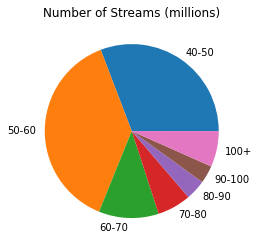

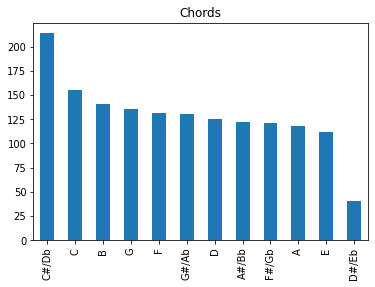

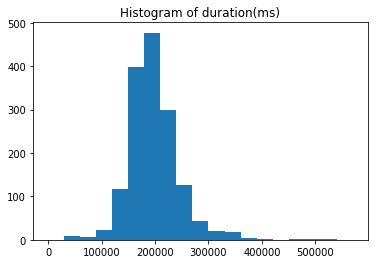

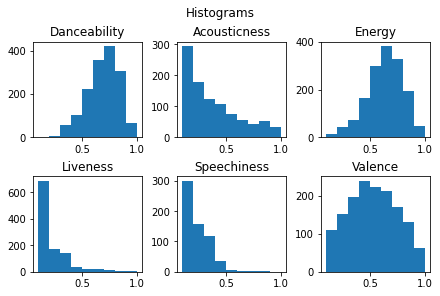

In [10]:
# Exploring

stream_bins = list(range(0, 10000001, 1000000)) + [99999999]
# streams = [int(stream.replace(',', '')) for stream in data['Streams'].tolist()]
hist, bin_edges = np.histogram(data['Streams'], bins=stream_bins)
percentages = hist/np.sum(hist)
labels = np.array(['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100+'])
labels = labels[percentages != 0]
percentages = percentages[percentages != 0]
fig, ax = plt.subplots(1, 1)
ax.pie(percentages, labels=labels)
ax.set_title('Number of Streams (millions)')
plt.show()

# should sort chords from low to high?
ax = data['Chord'].value_counts().plot.bar()
ax.set_title('Chords')
plt.show()

duration_bins = list(range(0, 30000*2*10, 30000))
fig, ax = plt.subplots(1, 1)
ax.hist(pd.to_numeric(data.iloc[:,-4]), bins=duration_bins)
ax.ticklabel_format(style='plain')
ax.set_title('Histogram of duration(ms)')
plt.show()

zero_to_one_bins = np.linspace(0.1, 1.0, 10)
fig, ax = plt.subplots(2, 3, constrained_layout=True)
zero_to_one_columns = ['Danceability', 'Acousticness', 'Energy', 'Liveness', 'Speechiness', 'Valence']
for i in range(len(zero_to_one_columns)):
    idx = np.unravel_index(i, (2, 3))
    ax[idx].hist(pd.to_numeric(data[zero_to_one_columns[i]]), bins=zero_to_one_bins)
    ax[idx].set_title(zero_to_one_columns[i])
fig.suptitle('Histograms')
plt.show()

In [11]:
# Exploring 

data.groupby('Number of Times Charted').describe()['Highest Charting Position']

,count,mean,std,min,25%,50%,75%,max
Number of Times Charted,,,,,,,,
1,504.0,129.716270,47.550004,5.0,88.00,134.0,172.25,200.0
2,149.0,83.758389,51.991508,10.0,43.00,67.0,113.00,194.0
3,110.0,82.845455,54.615619,2.0,34.00,71.0,128.00,193.0
4,76.0,86.894737,52.692461,10.0,50.50,71.5,130.50,194.0
5,70.0,79.357143,50.358724,3.0,39.75,69.5,118.50,189.0
...,...,...,...,...,...,...,...,...
81,2.0,61.000000,28.284271,41.0,51.00,61.0,71.00,81.0
82,2.0,57.000000,52.325902,20.0,38.50,57.0,75.50,94.0
83,18.0,24.777778,29.652012,1.0,4.00,13.0,29.25,99.0


In [12]:
# Exploring

data.corr(method='pearson')

,Highest Charting Position,Number of Times Charted,Streams,Artist Followers,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord_Class
Highest Charting Position,1.000000,-0.417748,-0.295442,-0.233723,-0.164167,0.017149,0.063026,0.032166,0.041248,-0.012924,0.012718,0.026235,-0.033956,0.045362,-0.005213
Number of Times Charted,-0.417748,1.000000,-0.060542,0.027458,0.232796,0.027026,-0.061139,0.031225,-0.060216,0.046651,-0.058436,-0.048307,0.033980,0.021570,0.015309
Streams,-0.295442,-0.060542,1.000000,0.103251,0.123184,-0.081291,0.004145,-0.031155,-0.062620,0.034054,0.042105,0.053458,0.015964,0.038381,0.006348
Artist Followers,-0.233723,0.027458,0.103251,1.000000,0.104358,-0.097576,-0.065613,-0.033264,-0.072968,0.023830,-0.012491,-0.019881,0.142145,-0.108804,-0.030136
Popularity,-0.164167,0.232796,0.123184,0.104358,1.000000,0.028435,0.094691,0.158767,-0.032091,-0.091245,-0.029460,-0.024951,0.082096,-0.000953,-0.019194
Danceability,0.017149,0.027026,-0.081291,-0.097576,0.028435,1.000000,0.142130,0.234928,0.237394,-0.316798,-0.114518,-0.040219,-0.101390,0.361627,0.049061
Energy,0.063026,-0.061139,0.004145,-0.065613,0.094691,0.142130,1.000000,0.732616,0.023989,-0.542399,0.124693,0.113352,0.056624,0.356325,0.026135
Loudness,0.032166,0.031225,-0.031155,-0.033264,0.158767,0.234928,0.732616,1.000000,-0.018823,-0.477431,0.043141,0.104371,0.075262,0.298762,-0.006913
Speechiness,0.041248,-0.060216,-0.062620,-0.072968,-0.032091,0.237394,0.023989,-0.018823,1.000000,-0.131436,0.072774,0.111255,-0.089895,0.038032,-0.007166
Acousticness,-0.012924,0.046651,0.034054,0.023830,-0.091245,-0.316798,-0.542399,-0.477431,-0.131436,1.000000,-0.005469,-0.061632,-0.046010,-0.096997,-0.023788


# Feature Engineering

In [13]:
# Data Scaling and Standardization
    

In [14]:
# Discretization/Binning


# Data Analysis

# Results